# 📚 Library Import

In [357]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc


import xgboost as xgb

# 📈 Processed Data Import

In [365]:
df = pd.read_csv('processed.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Pre-model Processing

In [366]:
# Need to convert the target column, 'y' into 0, 1 instead of no, yes
df['y'] = df['y'].replace('no', 0)
df['y'] = df['y'].replace('yes', 1)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


## Encoding categorical features

In [367]:
X = df.drop(['y'], axis = 1)
y = df['y']

I decided to label encode some of my features and one hot encode some others. I am going to label encode first.

In [368]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [369]:
X = MultiColumnLabelEncoder(columns = ['month', 'day_of_week', 'education']).fit_transform(X)
X.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,0,no,no,telephone,6,1,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,3,no,no,telephone,6,1,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,3,yes,no,telephone,6,1,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,1,no,no,telephone,6,1,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,3,no,yes,telephone,6,1,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


Now to one hot encode the rest of my features.

In [370]:
X = pd.get_dummies(X, drop_first = True)
X.head()

# Double check everything came out okay. 👍🏼

,age,education,month,day_of_week,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,job_student,job_technician,job_unemployed,marital_married,marital_single,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,56,0,6,1,1,0,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,1,1,0
1,57,3,6,1,1,0,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,1,1,0
2,37,3,6,1,1,0,0,1.1,93.994,-36.4,...,0,0,0,1,0,1,0,1,1,0
3,40,1,6,1,1,0,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,1,1,0
4,56,3,6,1,1,0,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,1,1,1,0


Manually scaling my data.

In [371]:
for col in X.columns:
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))

I am going to one hot encode some variables that were missed because they have numerical values.

In [281]:
pdays_dummies = pd.get_dummies(X['pdays'], drop_first = True, prefix = 'pdays')
previous_dummies = pd.get_dummies(X['previous'], drop_first = True, prefix = 'previous')

In [282]:
X = X.drop(['pdays', 'previous'], axis = 1)

In [283]:
X = pd.concat([X, pdays_dummies, previous_dummies], axis = 1)

In [284]:
X.head()

,age,education,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,poutcome_nonexistent,poutcome_success,pdays_1.0,previous_0.14285714285714285,previous_0.2857142857142857,previous_0.42857142857142855,previous_0.5714285714285714,previous_0.7142857142857143,previous_0.8571428571428571,previous_1.0
0,0.481481,0.000000,0.666667,0.25,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,...,1.0,0.0,0,0,0,0,0,0,0,0
1,0.493827,0.500000,0.666667,0.25,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,...,1.0,0.0,0,0,0,0,0,0,0,0
2,0.246914,0.500000,0.666667,0.25,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,...,1.0,0.0,0,0,0,0,0,0,0,0
3,0.283951,0.166667,0.666667,0.25,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,...,1.0,0.0,0,0,0,0,0,0,0,0
4,0.481481,0.500000,0.666667,0.25,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,...,1.0,0.0,0,0,0,0,0,0,0,0


In [285]:
X.columns

Index(['age', 'education', 'month', 'day_of_week', 'campaign', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'housing_yes', 'loan_yes', 'contact_telephone',
       'poutcome_nonexistent', 'poutcome_success', 'pdays_1.0',
       'previous_0.14285714285714285', 'previous_0.2857142857142857',
       'previous_0.42857142857142855', 'previous_0.5714285714285714',
       'previous_0.7142857142857143', 'previous_0.8571428571428571',
       'previous_1.0'],
      dtype='object')

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Oversampling the data before modeling

Technically this isn't required before beginning to model. However, my data has a class imbalance of almost 8:1. It's almost guaranteed that my models will perform better with the data oversampled.

In [404]:
oversample_x = pd.concat([X_train, y_train], axis=1)

In [405]:
no_only = oversample_x[oversample_x.y==0]
yes_only = oversample_x[oversample_x.y==1]

In [406]:
train_data_upsampled = resample(yes_only,
                          replace=True, 
                          n_samples=len(no_only), 
                          random_state=27) 

In [407]:
total_upsample = pd.concat([no_only, train_data_upsampled])

In [408]:
total_upsample['y'].value_counts()

1    27409
0    27409
Name: y, dtype: int64

In [409]:
new_y_train = total_upsample['y']
new_x_train = total_upsample.drop(['y'], axis = 1)

# Logistic Models

In [412]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(new_x_train, new_y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [413]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(new_x_train)

In [414]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

print('Training Precision: ', precision_score(new_y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(new_y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(new_y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(new_y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Confusion Matrix:
 [[6767 2372]
 [ 385  773]]
Training Precision:  0.7261543253134003
Testing Precision:  0.24578696343402226



Training Recall:  0.6805064030063118
Testing Recall:  0.6675302245250432



Training Accuracy:  0.7119376847021052
Testing Accuracy:  0.7322521122657084



Training F1-Score:  0.7025896977116489
Testing F1-Score:  0.35928422031141066


In [362]:
y_score = model_log.fit(new_x_train, new_y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [363]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7655062920947842


AUC: 0.7655062920947842


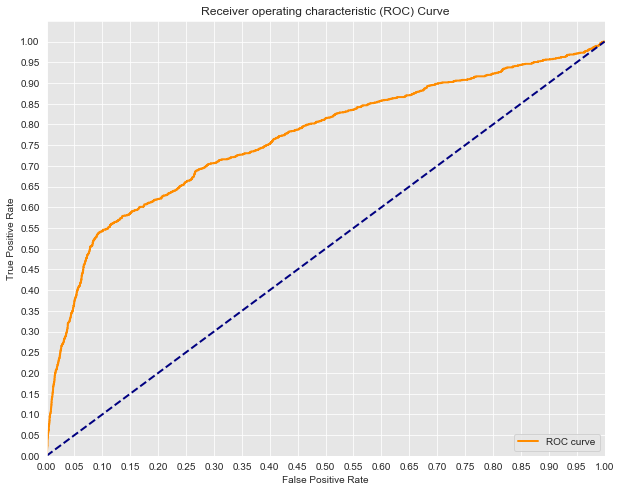

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# RFE

In [388]:
rfe = RFE(logreg, 10)
rfe.fit(new_x_train, new_y_train)


RFE(estimator=LogisticRegression(C=1000000000000.0, class_weight=None,
                                 dual=False, fit_intercept=False,
                                 intercept_scaling=1, l1_ratio=None,
                                 max_iter=100, multi_class='warn', n_jobs=None,
                                 penalty='l2', random_state=None,
                                 solver='liblinear', tol=0.0001, verbose=0,
                                 warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [389]:
rfe_hat_test = rfe.predict(X_test)
rfe_hat_train = rfe.predict(new_x_train)

In [390]:
cnf_matrix = confusion_matrix(y_test, rfe_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Training Precision: ', precision_score(new_y_train, rfe_hat_train))
print('Testing Precision: ', precision_score(y_test, rfe_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(new_y_train, rfe_hat_train))
print('Testing Recall: ', recall_score(y_test, rfe_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(new_y_train, rfe_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, rfe_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(new_y_train, rfe_hat_train))
print('Testing F1-Score: ', f1_score(y_test, rfe_hat_test))

Confusion Matrix:
 [[7297 1842]
 [ 415  743]]
Training Precision:  0.7586104386970739
Testing Precision:  0.2874274661508704



Training Recall:  0.6517202378780692
Testing Recall:  0.6416234887737479



Training Accuracy:  0.7221715494910431
Testing Accuracy:  0.780809944644071



Training F1-Score:  0.7011146871810974
Testing F1-Score:  0.3970077477958857


# Decision Trees

In [416]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5)

In [417]:
clf.fit(new_x_train, new_y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [418]:
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(new_x_train)

In [419]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

print('Training Precision: ', precision_score(new_y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(new_y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(new_y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(new_y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Confusion Matrix:
 [[7905 1234]
 [ 452  706]]
Training Precision:  0.8153860892891358
Testing Precision:  0.36391752577319586



Training Recall:  0.6210368856944799
Testing Recall:  0.6096718480138169



Training Accuracy:  0.740213068700062
Testing Accuracy:  0.8362629892201612



Training F1-Score:  0.7050636843740292
Testing F1-Score:  0.4557779212395094


# Random Forests

In [420]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth = 5,
                                criterion = 'entropy',
                                min_samples_leaf = 3,
                                min_samples_split = 5,
                               )
forest.fit(new_x_train, new_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [421]:
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(new_x_train)

In [422]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

print('Training Precision: ', precision_score(new_y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(new_y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(new_y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(new_y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Confusion Matrix:
 [[7905 1234]
 [ 452  706]]
Training Precision:  0.8153860892891358
Testing Precision:  0.36391752577319586



Training Recall:  0.6210368856944799
Testing Recall:  0.6096718480138169



Training Accuracy:  0.740213068700062
Testing Accuracy:  0.8362629892201612



Training F1-Score:  0.7050636843740292
Testing F1-Score:  0.4557779212395094


In [240]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [106]:
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)

In [111]:
rf_grid_search.fit(new_x_train, new_y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 92.164982%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [350]:
forest = RandomForestClassifier(n_estimators=10,
                                max_depth = 7,
                                criterion = 'entropy',
                                min_samples_leaf = 3,
                                min_samples_split = 5,
                                random_state = 15
                               )
forest.fit(new_x_train, new_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [351]:
y_hat_test = forest.predict(X_test)
y_hat_train = forest.predict(new_x_train)

In [352]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

print('Training Precision: ', precision_score(new_y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(new_y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(new_y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(new_y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Confusion Matrix:
 [[7990 1149]
 [ 457  701]]
Training Precision:  0.8266390879792198
Testing Precision:  0.37891891891891893



Training Recall:  0.6269838374256631
Testing Recall:  0.6053540587219344



Training Accuracy:  0.7477470903717757
Testing Accuracy:  0.8440322424006992



Training F1-Score:  0.7131001286360429
Testing F1-Score:  0.46609042553191493


# XGBoost

In [410]:
import xgboost as xgb
clf = xgb.XGBClassifier(learning_rate = .1, max_depth = 5, min_child_weight = 30, n_estimators = 30, random_state = 8)
clf.fit(new_x_train, new_y_train)
training_preds = clf.predict(new_x_train)
val_preds = clf.predict(X_test)

In [411]:
cnf_matrix = confusion_matrix(y_test, val_preds)
print('Confusion Matrix:\n', cnf_matrix)

print('TRAIN')
print(accuracy_score(new_y_train, training_preds))
print(recall_score(new_y_train, training_preds))
print(precision_score(new_y_train, training_preds))
print(f1_score(new_y_train, training_preds))
print('TEST')
print(accuracy_score(y_test, val_preds))
print(recall_score(y_test, val_preds))
print(precision_score(y_test, val_preds))
print(f1_score(y_test, val_preds))

Confusion Matrix:
 [[7950 1189]
 [ 428  730]]
TRAIN
0.7539859170345506
0.6503338319530081
0.8204077875454504
0.725537284272224
TEST
0.8429639700883752
0.6303972366148531
0.38040646169880143
0.4744881377965551


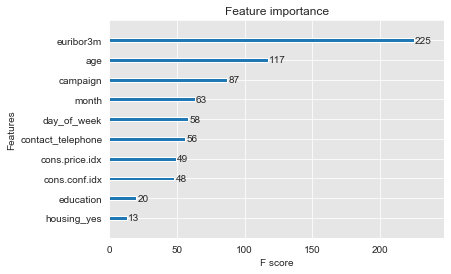

In [415]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(clf)
pyplot.show()

In [315]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

In [397]:
test_X = df.drop(['y', 'job', 'marital', 'loan', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'nr.employed'], axis = 1)
y = df['y']

In [398]:
test_X = MultiColumnLabelEncoder(columns = ['month', 'day_of_week', 'education']).fit_transform(test_X)
test_X.head()

,age,education,housing,contact,month,day_of_week,campaign,cons.price.idx,cons.conf.idx,euribor3m
0,56,0,no,telephone,6,1,1,93.994,-36.4,4.857
1,57,3,no,telephone,6,1,1,93.994,-36.4,4.857
2,37,3,yes,telephone,6,1,1,93.994,-36.4,4.857
3,40,1,no,telephone,6,1,1,93.994,-36.4,4.857
4,56,3,no,telephone,6,1,1,93.994,-36.4,4.857


In [400]:
test_X = pd.get_dummies(test_X, drop_first = True)
test_X.head()

# Double check everything came out okay. 👍🏼

,age,education,month,day_of_week,campaign,cons.price.idx,cons.conf.idx,euribor3m,housing_yes,contact_telephone
0,56,0,6,1,1,93.994,-36.4,4.857,0,1
1,57,3,6,1,1,93.994,-36.4,4.857,0,1
2,37,3,6,1,1,93.994,-36.4,4.857,1,1
3,40,1,6,1,1,93.994,-36.4,4.857,0,1
4,56,3,6,1,1,93.994,-36.4,4.857,0,1


In [401]:
for col in test_X.columns:
    test_X[col] = (test_X[col] - min(test_X[col]))/ (max(test_X[col]) - min(test_X[col]))

In [402]:
X_train, X_test, y_train, y_test = train_test_split(test_X, y, random_state=0)